In [1]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Implementation of a class to predict the S&P 500 Index
class IndexData():

  def __init__(self, dataset, sequence_length):
    self.sequence_length = sequence_length

    # Load and preprocess the data from the given link (to a GitHub repo file)
    self.market_data = pd.read_parquet(dataset)
    self.preprocess_data()

    # Set the divisor values from https://ycharts.com/indicators/sp_500_divisor#:~:text=S%26P%20500%20Divisor%20is%20at,0.23%25%20from%20one%20year%20ago
    # The divisor is used to calculate the S&P 500 Index based on the total
    # market cap for the given quarter and is in the millions
    self.divisors = {2013: {'Q1': 8934.61, 'Q2': 8908.33, 'Q3': 8908.77, 'Q4': 8896.86},
                     2014: {'Q1': 8924.03, 'Q2': 8919.22, 'Q3': 8878.54, 'Q4': 8882.35},
                     2015: {'Q1': 8861.60, 'Q2': 8851.25, 'Q3': 8830.99, 'Q4': 8810.57},
                     2016: {'Q1': 8757.39, 'Q2': 8718.72, 'Q3': 8667.94, 'Q4': 8643.59},
                     2017: {'Q1': 8606.26, 'Q2': 8581.63, 'Q3': 8567.30, 'Q4': 8565.26},
                     2018: {'Q1': 8535.74, 'Q2': 8518.41, 'Q3': 8474.31, 'Q4': 8434.96}}

    # Calculate the S&P 500 Index
    self.extract_index_data()

    # Split the data into training and testing (we'll use the first ~80% of prices
    # as training and the remaining ~20% as testing)
    self.train = self.index_data[:1000].iloc[:,2:].values
    self.test = self.index_data[1000:].iloc[:,2:].values

    # Standardize the Index data
    self.standardize()

    # Generate input and target sequences for the training and testing data
    self.x_train, self.y_train, self.x_test, self.y_test = self.generate_sequences()

  # Preprocess the given dataset
  def preprocess_data(self):
    # Drop all unnecessary columns
    # We will only need the date, closing price, and volume
    self.market_data.drop(columns=['open', 'high', 'low', 'Name'], inplace=True)
    column_names = self.market_data.columns

    # Remove all rows with empty or missing values
    self.market_data.dropna(inplace=True)

    # Drop any duplicate rows
    self.market_data.drop_duplicates(inplace=True)

    # Convert the date column to datetime format
    self.market_data['date'] = pd.to_datetime(self.market_data['date'], format='%Y-%m-%d')

  # Calculate the S&P 500 Index using the closing price for every day
  def extract_index_data(self):
    # Calculate the numerator to calculate the Index and group by the date
    self.market_data['index_numerator'] = self.market_data['close'] * self.market_data['volume']
    self.market_data.drop(columns=['close', 'volume'], inplace=True)
    self.index_data = self.market_data.groupby(['date']).sum().reset_index()

    # Apply the appropriate divisor based on the quarter
    def apply_divisor(row):
      # Q1 for January-March
      if row['date'].month in [1,2,3]:
        quarter = 'Q1'
      # Q2 for April-June
      elif row['date'].month in [4,5,6]:
        quarter = 'Q2'
      # Q3 for July-September
      elif row['date'].month in [7,8,9]:
        quarter = 'Q3'
      # Q4 for October-December
      else:
        quarter = 'Q4'
      return float(row['index_numerator']) / (self.divisors[row['date'].year][quarter] * 1e4)

    # Apply the divisor for every date's numerator
    self.index_data['index'] = self.index_data.apply(apply_divisor, axis=1)

  # Standardize the index data
  def standardize(self):
    self.scaler = MinMaxScaler(feature_range=(0,1))
    self.train = self.scaler.fit_transform(self.train)
    self.test = self.scaler.fit_transform(self.test)

  # Generate input and target sequences for the training and testing data
  def generate_sequences(self):
    x_train_sequences, y_train_sequences, x_test_sequences, y_test_sequences = [], [], [], []

    # Training sequences
    for i in range(self.sequence_length, len(self.train) - 1):
      x_train_sequences.append(self.train[i-self.sequence_length : i,0])
      y_train_sequences.append(self.train[i : i+1,0])

    # Testing sequences
    for i in range(self.sequence_length, len(self.test) - 1):
      x_test_sequences.append(self.test[i-self.sequence_length : i,0])
      y_test_sequences.append(self.test[i : i+1,0])

    # Convert all sequences to numpy arrays
    x_train_sequences = np.array(x_train_sequences)
    y_train_sequences = np.array(y_train_sequences)
    x_test_sequences = np.array(x_test_sequences)
    y_test_sequences = np.array(y_test_sequences)

    # Reshape x data to fit as input to GRU
    x_train_sequences = np.reshape(x_train_sequences, (1, x_train_sequences.shape[0], x_train_sequences.shape[1]))
    x_test_sequences = np.reshape(x_test_sequences, (1, x_test_sequences.shape[0], x_test_sequences.shape[1]))

    return x_train_sequences, y_train_sequences, x_test_sequences, y_test_sequences


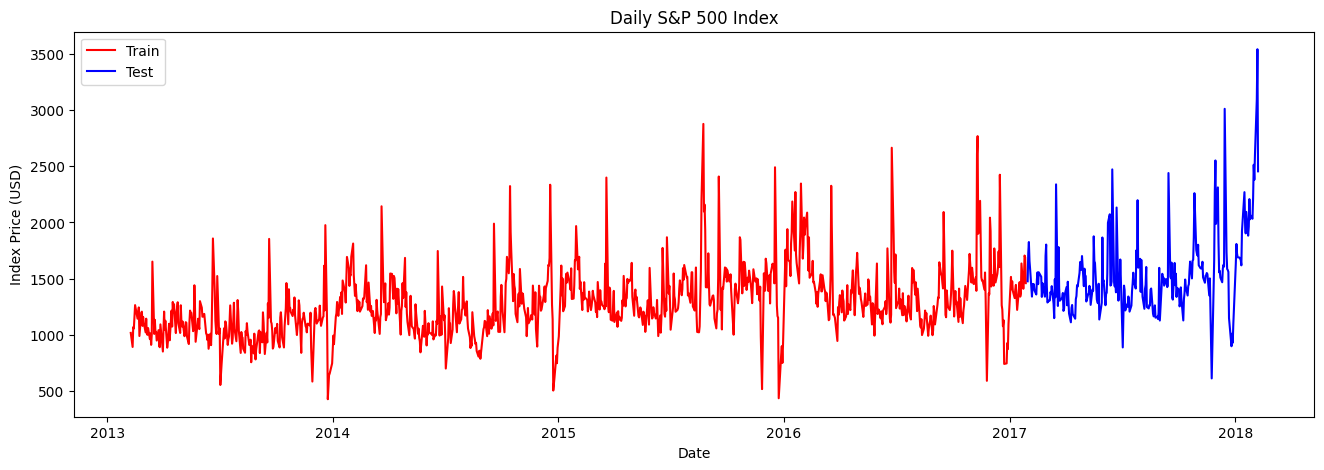

In [3]:
index_data_obj = IndexData('https://github.com/nikhilmanda9/ML-Stock-Market-Prediction/blob/main/all_stocks_5yr.parquet?raw=true', 5)

# Visualize the computed S&P 500 Index
fig = plt.subplots(figsize=(16, 5))
plt.plot(index_data_obj.index_data["date"][:1000], index_data_obj.index_data["index"][:1000], color='r')
plt.plot(index_data_obj.index_data["date"][1000:], index_data_obj.index_data["index"][1000:], color='b')
plt.title("Daily S&P 500 Index")
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Index Price (USD)')
plt.show()

In [4]:
# Implementation of the GRU model
class GRU:

    # Randomly initialize weight and bias matrices with the given input and
    # hidden layer sizes
    def __init__(self, x_train, y_train, learning_rate, num_epochs, input_size, hidden_size, output_size, sequence_length):
      self.x_train = x_train
      self.y_train = y_train
      self.learning_rate = learning_rate
      self.num_epochs = num_epochs
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.num_sequences, self.sequence_length = self.x_train.shape[1], self.x_train.shape[2]
      self.weights = {}

      # Weights and bias for Update gate
      self.weights['W_xz'] = np.random.randn(self.hidden_size, self.input_size)
      self.weights['W_hz'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_z'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Reset gate
      self.weights['W_xr'] = np.random.randn(self.hidden_size, self.input_size)
      self.weights['W_hr'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_r'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Candidate hidden state
      self.weights['W_xh'] = np.random.randn(self.hidden_size, self.input_size)
      self.weights['W_hh'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_h'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for output
      self.weights['W_o'] = np.random.randn(self.output_size, self.hidden_size)
      self.weights['b_o'] = np.zeros((self.output_size, 1))

      # Hidden state information
      self.ho = np.zeros((self.hidden_size, self.num_sequences))
      self.dh = np.zeros((self.hidden_size, self.num_sequences, self.sequence_length))

    # Train the model for the given number of epochs
    def fit(self):
      self.train_errs = []
      for epoch in range(self.num_epochs):

        # Forward pass
        preds, h, layer_params = self.forward()

        # Compute Mean Sum of Squared Error
        train_err = np.sum(np.square((preds - self.y_train))) / (self.sequence_length * self.num_sequences)
        self.train_errs.append(train_err)

        # Backprogapation
        self.backpropagate(layer_params)

        # Update Weights, Biases, and State parameters
        for w in self.weights:
          if w not in ['W_o', 'b_o']:
            self.weights[w] -= np.multiply(self.learning_rate, self.gradients['d' + w])
        self.dh -= np.multiply(self.learning_rate, self.gradients['dh_previous'])

    # Forward propagation logic for the (entire) GRU model
    def forward(self):
      # Store the calculated paramaters for every layer to use during backpropagation
      layer_parameters = []

      # Initialize state information
      h = np.zeros((self.hidden_size, self.num_sequences, self.sequence_length))
      preds = np.zeros((self.output_size, self.num_sequences, self.sequence_length))
      h_out = self.ho

      # Go through every layer/cell in the GRU model
      for layer in range(self.sequence_length):
        layer_preds, h_out, layer_params = self.forward_(self.x_train[:,:,layer], h_out)
        h[:,:,layer] = h_out
        preds[:,:,layer] = layer_preds
        layer_parameters.append(layer_params)

      return preds, h, layer_parameters

    # Forward propagation logic for the GRU model (for each individual layer/cell)
    def forward_(self, x, h_previous):

      # Update gate computation with sigmoid activation function
      z = self.sigmoid(np.dot(self.weights['W_xz'], x) + np.dot(self.weights['W_hz'], h_previous) + self.weights['b_z'])

      # Reset gate computation with sigmoid activation function
      r = self.sigmoid(np.dot(self.weights['W_xr'], x) + np.dot(self.weights['W_hr'], h_previous) + self.weights['b_r'])

      # Candidate hidden state computation with tanh activation function
      h_hat = self.tanh(np.dot(self.weights['W_xh'], x) + np.dot(self.weights['W_hh'], r * h_previous) + self.weights['b_h'])

      # Update the hidden state
      h_out = np.multiply(z, h_previous) + np.multiply((1 - z), h_hat)

      # Predict the output for the given input
      preds = np.dot(self.weights['W_o'], h_out) + self.weights['b_o']

      # Store the computed parameters for backpropagation
      layer_params = [z, r, h_hat, h_out, h_previous, x]

      return preds, h_out, layer_params

    # Sigmoid activation function
    def sigmoid(self, x):
      return (1 / (1 + np.exp(-x)))

    # Derivative of sigmoid activation function
    def d_sigmoid(self, x):
      return np.multiply(self.sigmoid(x), 1 - self.sigmoid(x))

    # Tanh activation function
    def tanh(self, x):
      return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))

    # Derivative of Tanh activation function
    def d_tanh(self, x):
      return 1 - np.square(self.tanh(x))

    # Backpropagation logic for the (entire) GRU model
    def backpropagate(self, layer_params):
      self.gradients = {}

      # Weights and bias for Update gate
      self.gradients['dW_xz'] = np.random.randn(self.hidden_size, self.input_size)
      self.gradients['dW_hz'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_z'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Reset gate
      self.gradients['dW_xr'] = np.random.randn(self.hidden_size, self.input_size)
      self.gradients['dW_hr'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_r'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Candidate hidden state
      self.gradients['dW_xh'] = np.random.randn(self.hidden_size, self.input_size)
      self.gradients['dW_hh'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_h'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for output
      self.gradients['dx'] = np.zeros((self.input_size, self.num_sequences, self.sequence_length))
      self.gradients['dh_previous'] = np.zeros((self.hidden_size, self.num_sequences, self.sequence_length))

      # Go through every layer/cell in the GRU model
      for layer in range(self.sequence_length-1, -1, -1):
        self.backpropagate_(self.dh[:,:,layer], layer, layer_params[layer])

    def backpropagate_(self, dh, layer, layer_params):
      # Get the gradient of each computed parameter from layer parameters
      z, r, h_hat, h_out, h_previous, x = layer_params

      # Update gate gradient
      dz1 = np.multiply(dh, h_hat)
      dz2 = np.multiply(dh, h_previous)
      dz3 = dz1 + 1 - dz2
      dz4 = self.d_sigmoid(z)
      dz = np.multiply(dz3, dz4)

      # Candidate hidden state gradient
      dhhat1 = np.multiply(dh, z)
      dhhat2 = self.d_tanh(h_hat)
      dhhat = np.multiply(dhhat1, dhhat2)

      # Reset gate gradient
      dr1 = np.dot(np.transpose(self.weights["W_hh"]), dhhat)
      dr2 = np.multiply(dr1, r)
      dr3 = self.d_sigmoid(r)
      dr = np.multiply(dr2, dr3)

      # Hidden state gradient
      dh1 = np.dot(np.transpose(self.weights["W_hh"]), dhhat)
      dh2 = np.multiply(dh1, r)
      dh3 = np.multiply(1- z, dh)
      dh4 = np.dot(np.transpose(self.weights["W_hh"]), dr)
      dh5 = np.dot(np.transpose(self.weights["W_hh"]), dz)
      dh = dh2 + dh3 + dh4 + dh5

      # Output gradient
      dx1 = np.dot(np.transpose(self.weights["W_xh"]), dhhat)
      dx2 = np.dot(np.transpose(self.weights["W_xh"]), dz)
      dx3 = np.dot(np.transpose(self.weights["W_xh"]), dr)
      dx = dx1 + dx2 + dx3

      # Compute the final weight and bias gradients

      # Update gate weights and bias
      self.gradients['dW_xz'] += np.dot(dz, np.transpose(x))
      self.gradients['dW_hz'] += np.dot(dz, np.transpose(h_previous))
      self.gradients['db_z'] += np.sum(dz, axis=1, keepdims=True)

      # Reset gate weights and bias
      self.gradients['dW_xr'] += np.dot(dr, np.transpose(x))
      self.gradients['dW_hr'] += np.dot(dr, np.transpose(h_previous))
      self.gradients['db_r'] += np.sum(dr, axis=1, keepdims=True)

      # Weights and bias for Candidate hidden state
      self.gradients['dW_xh'] += np.dot(dh, np.transpose(x))
      self.gradients['dW_hh'] += np.dot(dh, np.transpose(np.multiply(h_previous, r)))
      self.gradients['db_h'] += np.sum(dh, axis=1, keepdims=True)

      # Output and hidden state gradients
      self.gradients['dx'][:,:,layer] = dx
      self.gradients['dh_previous'][:,:,layer] = dh

    # Prediction logic for the (entire) GRU model
    def predict(self, x_test):
      # Initialize state information
      h = np.zeros((self.hidden_size, x_test.shape[1], self.sequence_length))
      preds = np.zeros((self.output_size, x_test.shape[1], self.sequence_length))
      h_out = np.zeros((self.hidden_size, x_test.shape[1]))

      # Go through every layer/cell in the GRU model
      for layer in range(self.sequence_length):
        layer_preds, h_out = self.predict_(x_test[:,:,layer], h_out)
        h[:,:,layer] = h_out
        preds[:,:,layer] = layer_preds

      return preds

    # Prediction logic for the GRU model (for each individual layer/cell)
    def predict_(self, x, h_previous):

      # Update gate computation with sigmoid activation function
      z = self.sigmoid(np.dot(self.weights['W_xz'], x) + np.dot(self.weights['W_hz'], h_previous) + self.weights['b_z'])

      # Reset gate computation with sigmoid activation function
      r = self.sigmoid(np.dot(self.weights['W_xr'], x) + np.dot(self.weights['W_hr'], h_previous) + self.weights['b_r'])

      # Candidate hidden state computation with tanh activation function
      h_hat = self.tanh(np.dot(self.weights['W_xh'], x) + np.dot(self.weights['W_hh'], r * h_previous) + self.weights['b_h'])

      # Update the hidden state
      h_out = np.multiply(z, h_previous) + np.multiply((1 - z), h_hat)

      # Predict the output for the given input
      preds = np.dot(self.weights['W_o'], h_out) + self.weights['b_o']

      return preds, h_out

In [5]:
# Create a log file and try different parameters for the GRU model
with open("gru_logs.txt", 'w') as logfile:
  # Different values for our parameters
  sequence_lengths = [3,4,5]

  learning_rates = [0.0001, 0.00001, 0.000001]
  epochs = [25, 50, 100]
  hidden_sizes = [5, 10, 20]

  # Store the parameters and errors after training the GRU model
  values = []

  # The cartesian product of all possible parameters
  for sequence_length, learning_rate, num_epochs, hidden_size in itertools.product(sequence_lengths,
                                                                                   learning_rates,
                                                                                   epochs,
                                                                                   hidden_sizes):
    # Train the GRU model with the given parameters
    # We keep the sequences in a Many-One structure (input sequences have multiple values
    # while output sequence will always be of length one)
    index_data_obj = IndexData('https://github.com/nikhilmanda9/ML-Stock-Market-Prediction/blob/main/all_stocks_5yr.parquet?raw=true',
                               sequence_length)

    gru = GRU(x_train=index_data_obj.x_train,
          y_train=index_data_obj.y_train,
          learning_rate=learning_rate,
          num_epochs=num_epochs,
          input_size=1,
          hidden_size=hidden_size,
          output_size=1,
          sequence_length=sequence_length)
    gru.fit()

    # Get the final training and testing errors
    train_err = gru.train_errs[-1]
    testing_output = gru.predict(index_data_obj.x_test)
    test_err = np.sum(np.square((testing_output - index_data_obj.y_test))) / (sequence_length * gru.num_sequences)

    values.append([sequence_length,
                   learning_rate,
                   num_epochs,
                   hidden_size,
                   train_err,
                   test_err])

  # Write the parameters and errors to the logfile
  logfile.write(tabulate(values,
                headers=['Sequence Length', 'Learning Rate', 'Number of Epochs',
                         'Hidden Size', 'Training Error', 'Testing Error'],
                floatfmt=["", "", "", "", ".4f", ".4f"]))

<ipython-input-4-faf97ccf34ab>:113: RuntimeWarning: overflow encountered in exp
  return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))
<ipython-input-4-faf97ccf34ab>:113: RuntimeWarning: invalid value encountered in divide
  return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))
<ipython-input-4-faf97ccf34ab>:113: RuntimeWarning: overflow encountered in exp
  return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))
<ipython-input-4-faf97ccf34ab>:113: RuntimeWarning: invalid value encountered in divide
  return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))
<ipython-input-4-faf97ccf34ab>:113: RuntimeWarning: overflow encountered in exp
  return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))
<ipython-input-4-faf97ccf34ab>:113: RuntimeWarning: invalid value encountered in divide
  return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))
<ipython-input-4-faf97ccf34ab>:113: RuntimeWarning: overflow encountered in exp
  return ((np.exp(x) - np.exp(-x)) / (

In [7]:
# Extract the best parameters based on the lowest average Training and Testing Errors
best_sequence_length, best_learning_rate, best_num_epochs, best_hidden_size = None, None, None, None
best_train_err, best_test_err, best_avg_err = None, None, 1e9
for sequence_length, learning_rate, num_epochs, hidden_size, train_err, test_err in values:
  avg_err = (train_err + test_err) / 2
  if avg_err < best_avg_err:
    best_sequence_length = sequence_length
    best_learning_rate = learning_rate
    best_num_epochs = num_epochs
    best_hidden_size = hidden_size
    best_train_err = train_err
    best_test_err = test_err
    best_avg_err = avg_err

print("Sequence Length: {}\nLearning Rate: {}\nNumber of Epochs: {}\nHidden Size: {}\nTraining Error: {:.4f}\nTesting Error: {:.4f}".format(
    best_sequence_length, best_learning_rate, best_num_epochs, best_hidden_size, best_train_err, best_test_err))

Sequence Length: 5
Learning Rate: 1e-06
Number of Epochs: 100
Hidden Size: 5
Training Error: 0.0520
Testing Error: 0.0123


Text(0, 0.5, 'Error')

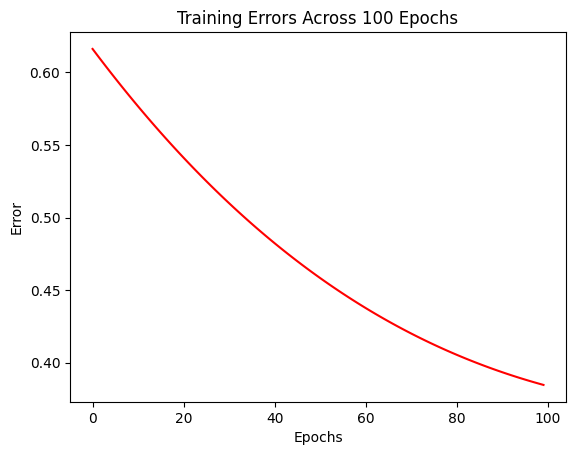

In [9]:
# Run the model with the best set of parameters and plot the training error for each epoch
index_data_obj = IndexData('https://github.com/nikhilmanda9/ML-Stock-Market-Prediction/blob/main/all_stocks_5yr.parquet?raw=true',
                               best_sequence_length)
gru = GRU(x_train=index_data_obj.x_train,
          y_train=index_data_obj.y_train,
          learning_rate=best_learning_rate,
          num_epochs=best_num_epochs,
          input_size=1,
          hidden_size=best_hidden_size,
          output_size=1,
          sequence_length=best_sequence_length)
gru.fit()

# Plot the errors
x = np.arange(0, best_num_epochs)
plt.plot(x, gru.train_errs, "r")
plt.title("Training Errors Across {} Epochs".format(best_num_epochs))
plt.xlabel("Epochs")
plt.ylabel("Error")

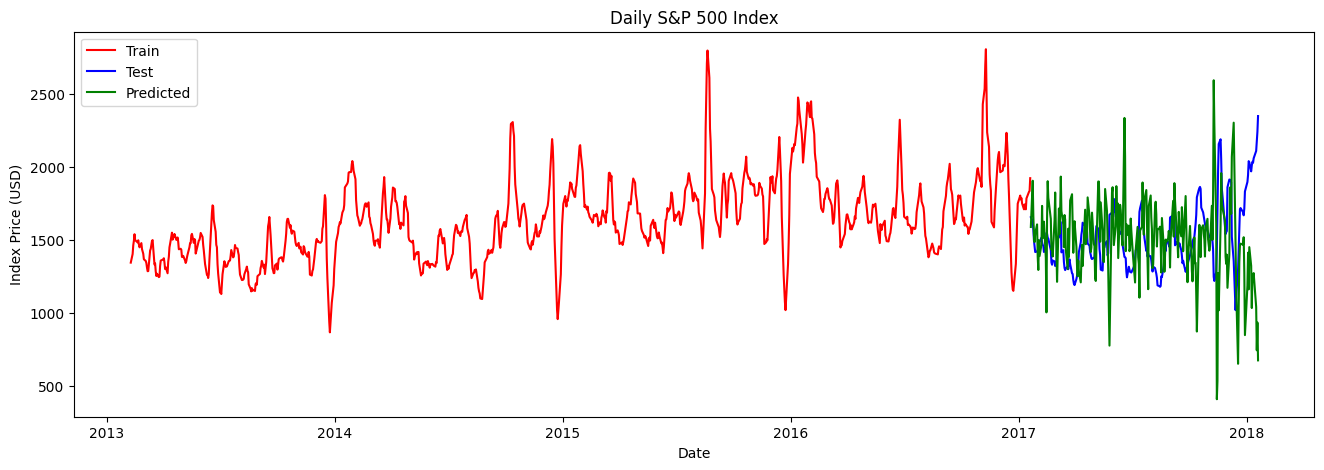

In [11]:
# Visualize the computed S&P 500 Index
fig = plt.subplots(figsize=(16, 5))
x_train = index_data_obj.scaler.inverse_transform(gru.x_train[0])
x_train = [np.mean(arr) for arr in x_train]
x_test = index_data_obj.scaler.inverse_transform(index_data_obj.x_test[0][:-1])
x_test = [np.mean(arr) for arr in x_test]
y_test = index_data_obj.scaler.inverse_transform(gru.predict(index_data_obj.x_test)[0][:-1])
y_test = [np.max(arr) for arr in y_test]
plt.plot(index_data_obj.index_data["date"][:994], x_train, color='r')
plt.plot(index_data_obj.index_data["date"][994:1246], x_test, color='b')
plt.plot(index_data_obj.index_data["date"][994:1246], y_test, color='g')
plt.title("Daily S&P 500 Index")
plt.legend(['Train', 'Test', 'Predicted'])
plt.xlabel('Date')
plt.ylabel('Index Price (USD)')
plt.show()